In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as cm
from braindecode.datautil.signal_target import SignalAndTarget
from braindecode.models.shallow_fbcsp import ShallowFBCSPNet
from torch import nn
from braindecode.torch_ext.util import set_random_seeds
from torch import optim
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
sys.path.append(os.getcwd())
import conf_mat as plot_cm
# Convert data from volt to millivolt
# Pytorch expects float32 for input and int64 for labels.

### load and manipulate dataset

In [24]:
intra_sbj = False
sbj_num = 8
labels = ["episode_type","trial_type","trial_num",
          "episode_num","is_corrupt","action_index",
          "trimmed_data","left","subject_num","win"]

data = pd.read_pickle("data/data_processed.pkl")
# data = data[data.is_corrupt == 0] #remove corrupt readings
# data = data.assign(win = lambda x: x.episode_type.isin([0,3])*1) #create win column. 1 if won, 0 if lost.
# data = data.assign(left = lambda x: x.episode_type.isin([0,1])*1) #create left column. 1 if the reward is on the left, 0 if it's on the right.
if intra_sbj:
    data = data[data.subject_num == sbj_num].reset_index(drop=True)
data.describe()

,0,1,2,3,4,5,6,7,8,9,...,episode_type,trial_type,trial_num,episode_num,is_corrupt,action_index,trimmed_data,left,subject_num,win
count,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,...,1161.000000,1161.000000,1161.000000,1161.000000,1161.0,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000
mean,3.218856,3.162438,3.032076,2.906566,2.871996,2.893409,2.963716,3.173706,3.499746,3.733398,...,1.551249,0.485788,19.989664,14.476314,0.0,1025.596038,34.442722,0.484927,5.433247,0.616710
std,4.183078,4.249418,4.160004,3.824425,3.636471,3.446742,3.508674,3.650501,3.972553,4.129333,...,1.217403,0.500013,11.250589,8.650274,0.0,8.674554,8.294080,0.499988,2.878139,0.486398
min,-35.408770,-36.062234,-33.722579,-32.042085,-32.244882,-35.319178,-33.218692,-27.933940,-21.588737,-18.657739,...,0.000000,0.000000,1.000000,0.000000,0.0,987.000000,1.000000,0.000000,1.000000,0.000000
25%,1.817760,1.689197,1.566943,1.580397,1.559179,1.667601,1.716362,1.800247,1.942850,2.177716,...,0.000000,0.000000,10.000000,7.000000,0.0,1024.000000,34.000000,0.000000,3.000000,0.000000
50%,3.157827,3.134136,2.986542,2.927393,2.839963,2.892483,2.974394,3.105543,3.570791,3.762869,...,2.000000,0.000000,20.000000,14.000000,0.0,1025.000000,34.000000,0.000000,5.000000,1.000000
75%,4.570747,4.528262,4.426292,4.301215,4.162741,4.280895,4.363857,4.758344,5.391475,5.472068,...,3.000000,1.000000,30.000000,22.000000,0.0,1025.000000,38.000000,1.000000,8.000000,1.000000
max,33.056650,33.770907,37.167198,24.965349,24.877358,24.692057,24.913644,21.628917,33.449568,45.827411,...,3.000000,1.000000,39.000000,29.000000,0.0,1062.000000,76.000000,1.000000,10.000000,1.000000


### split into X and y, train and test sets

In [26]:
x = data.drop(labels, axis=1) #cut the first and last x,y readings out of each row
x = x[list(range(150,345))]
x = x.fillna(x.mean()) #fill the NaN values with the means of the columns
y = data['win'] #use newly created win column

In [27]:
x = x.values.reshape(x.shape[0], 1, x.shape[1]) #convert to numpy array and reshape to (trials, channels, num_readings)
x = x.astype('float32') #convert values to float32. apparently pytorch needs this

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.33, random_state=27)

In [29]:
train_set = SignalAndTarget(x_train, y=y_train)
test_set = SignalAndTarget(x_test, y=y_test)

### initialize shallow CNN

In [30]:
# Set if you want to use GPU
# You can also use torch.cuda.is_available() to determine if cuda is available on your machine.
cuda = False
set_random_seeds(seed=20170629, cuda=cuda)
n_classes = 2
in_chans = train_set.X.shape[1] #only one channel
# final_conv_length = auto ensures we only get a single output in the time dimension
model = ShallowFBCSPNet(in_chans=in_chans, n_classes=n_classes,
                        input_time_length=train_set.X.shape[2],
                        final_conv_length='auto').create_network()
if cuda:
    model.cuda()

### specify optimizer and train/test loop

In [31]:
optimizer = optim.Adam(model.parameters())

In [32]:
from braindecode.torch_ext.util import np_to_var, var_to_np
from braindecode.datautil.iterators import get_balanced_batches
import torch.nn.functional as F
from numpy.random import RandomState
rng = RandomState((2017,6,30))

epochs = 50
train_perf = []
test_perf = []

for i_epoch in range(epochs):
    i_trials_in_batch = get_balanced_batches(len(train_set.X), rng, shuffle=True,
                                            batch_size=30)
#     print("minibatches:",len(i_trials_in_batch))
    # Set model to training mode
    model.train()
    for i_trials in i_trials_in_batch:
        # Have to add empty fourth dimension to X
        batch_X = train_set.X[i_trials][:,:,:,None]
        batch_y = train_set.y[i_trials]
        net_in = np_to_var(batch_X)
        if cuda:
            net_in = net_in.cuda()
        net_target = np_to_var(batch_y)
        if cuda:
            net_target = net_target.cuda()
        # Remove gradients of last backward pass from all parameters
        optimizer.zero_grad()
        # Compute outputs of the network
        outputs = model(net_in)
        # Compute the loss
        net_target = net_target.long()
        loss = F.nll_loss(outputs, net_target)
        # Do the backpropagation
        loss.backward()
        # Update parameters with the optimizer
        optimizer.step()

    # Print some statistics each epoch
    model.eval()
    for setname, dataset in (('Train', train_set), ('Test', test_set)):
        # Here, we will use the entire dataset at once, which is still possible
        # for such smaller datasets. Otherwise we would have to use batches.
        net_in = np_to_var(dataset.X[:,:,:,None])
        if cuda:
            net_in = net_in.cuda()
        net_target = np_to_var(dataset.y)
        if cuda:
            net_target = net_target.cuda()
        outputs = model(net_in)
        loss = F.nll_loss(outputs, net_target)
#         print("{:6s} Loss: {:.5f}".format(
#             setname, float(var_to_np(loss))))
        predicted_labels = np.argmax(var_to_np(outputs), axis=1)
        true_labels = dataset.y.values
        if i_epoch%10 ==0:
            print("Epoch {:d}".format(i_epoch))
            print("{:6s} Accuracy: {:.1f}%".format(setname, accuracy * 100))
#             print("predicted",predicted_labels)
#             print("true",true_labels,"\n\n\n")
        accuracy = np.mean(dataset.y  == predicted_labels)

        
        #create arrays to graph
        if(setname == 'Train'):
            train_perf.append(accuracy*100)
        else:
            test_perf.append(accuracy*100)
            
        if(i_epoch == epochs-1 and setname == 'Test'):
            conf = cm(true_labels, predicted_labels)
            print(conf)

/Users/adamnoack/anaconda/envs/rllab3/lib/python3.5/site-packages/pandas/core/series.py:696: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/Users/adamnoack/anaconda/envs/rllab3/lib/python3.5/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 0
Train  Accuracy: 46.6%
Epoch 0
Test   Accuracy: 42.2%
Epoch 10
Train  Accuracy: 40.1%
Epoch 10
Test   Accuracy: 37.6%
Epoch 20
Train  Accuracy: 53.4%
Epoch 20
Test   Accuracy: 41.6%
Epoch 30
Train  Accuracy: 45.3%
Epoch 30
Test   Accuracy: 50.7%
Epoch 40
Train  Accuracy: 56.0%
Epoch 40
Test   Accuracy: 48.5%
[[109  47]
 [161  67]]


### confusion matrix

Confusion matrix, without normalization
[[109  47]
 [161  67]]


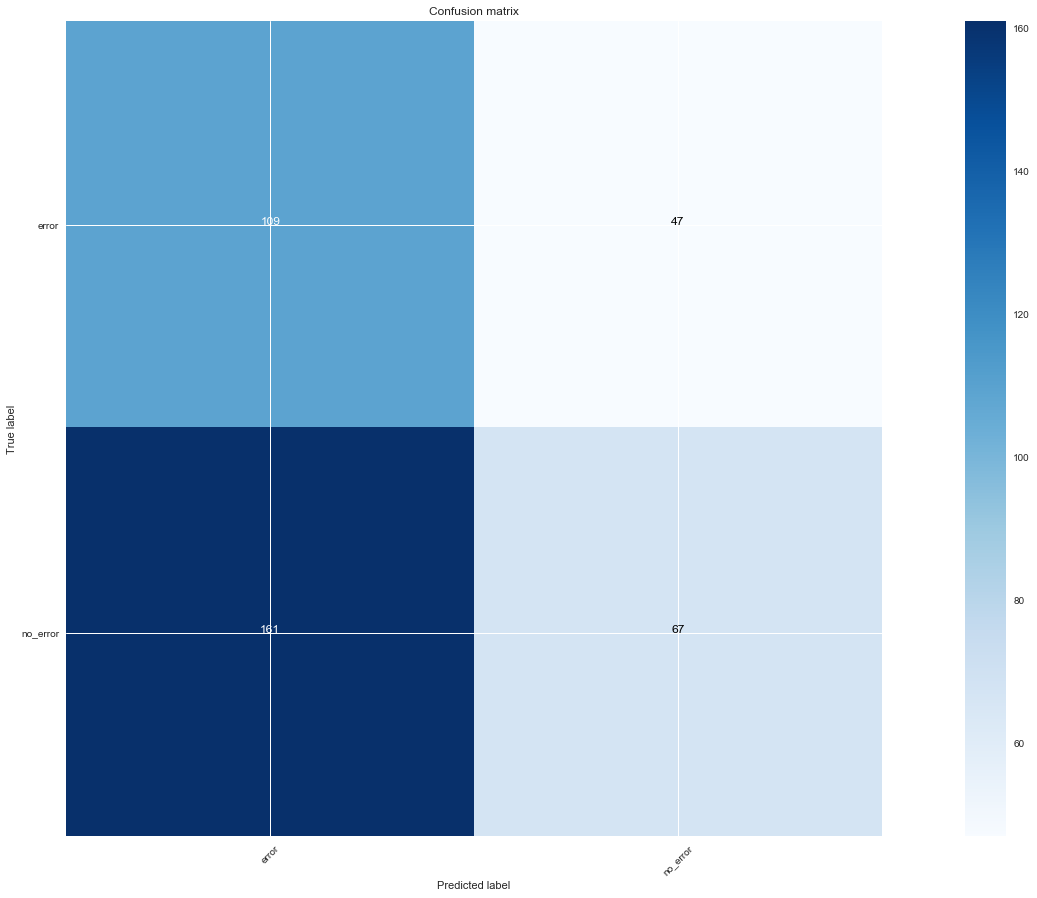

In [33]:
plt.figure()
plot_cm.plot_confusion_matrix(conf,["error","no_error"],normalize=False)
plt.savefig('../thesis/figures/cm_all_subjects.png', bbox_inches='tight')
plt.show()

### plot learning curves

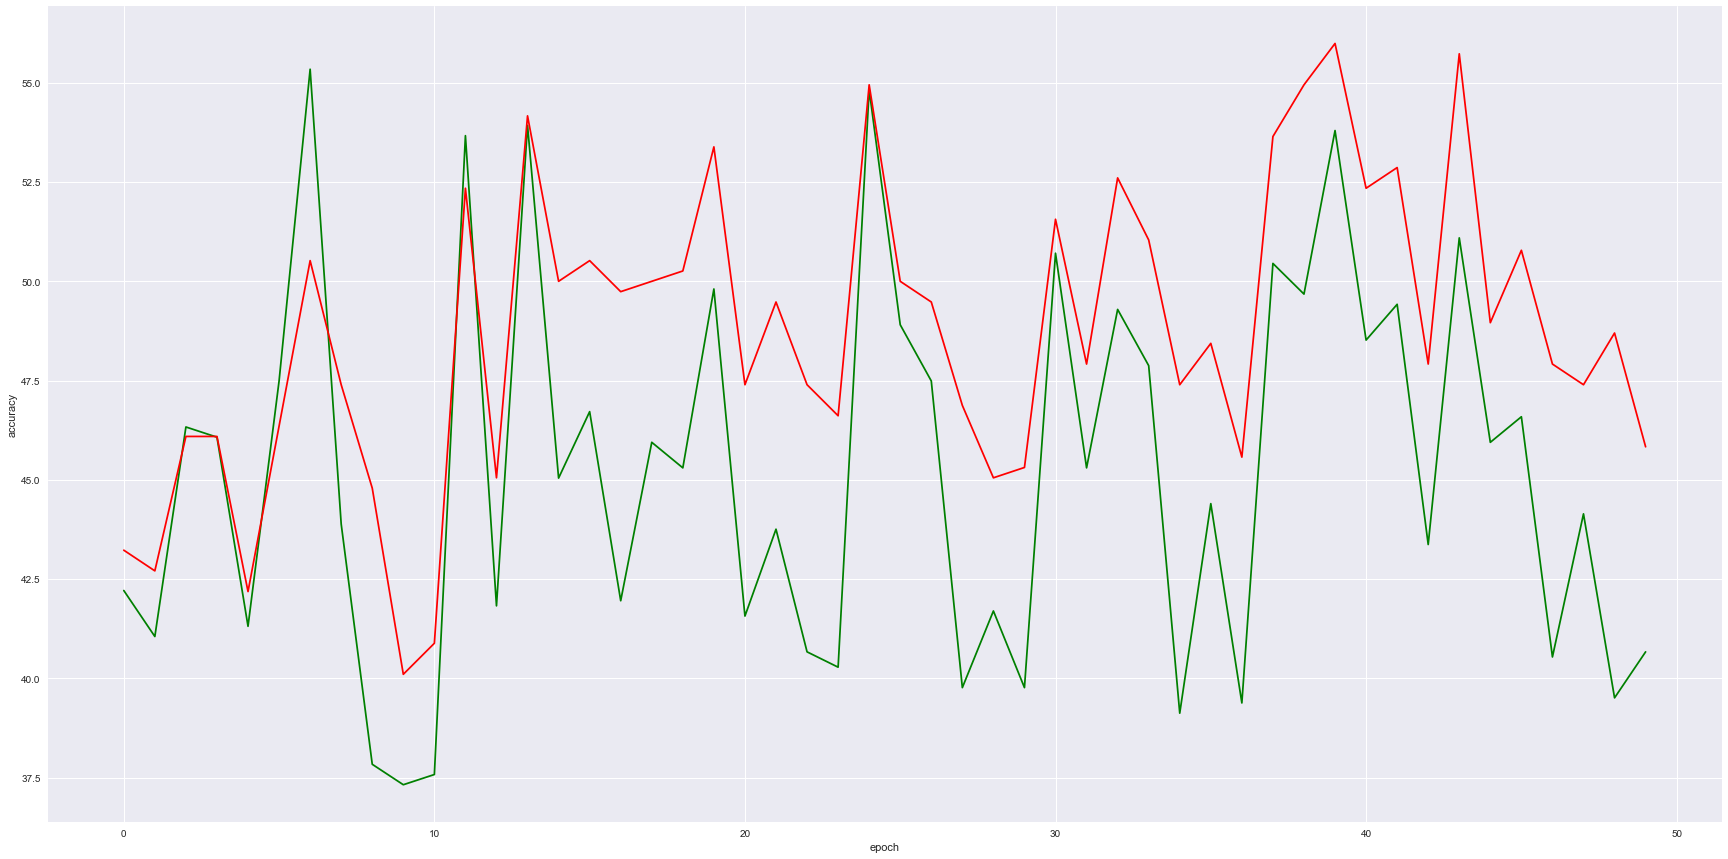

In [34]:
sns.set(style="darkgrid")
plt.rcParams["figure.figsize"] = [30,15]

# plt.plot(ave_person)
plt.plot(train_perf, color="green")
plt.plot(test_perf, color="red")

plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()